# Closure test of Bayesian analysis

In [1]:
# prepare
import subprocess
from multiprocessing import Pool, cpu_count
import os, pickle, math, time

import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set("notebook")
sns.color_palette('Set2')
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee
import h5py

FW = 600

path = '/mnt/d/research/Bayesian/BayesianAnalysis-Tequila'

def save_fig(fig_id):
    plt.savefig(path+fig_id, format='png', dpi=300)
    
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)


## Gaussian emulator

In [2]:
# Gaussian emulator

simulation = np.loadtxt(os.path.join(path, 'data', 'running_coupling', 'output_4obs'))
simulation_err = np.loadtxt(os.path.join(path, 'data', 'running_coupling', 'output_err_4obs'))

use_NL = False
Y_model = np.sqrt(simulation) if use_NL else simulation

SS  =  StandardScaler(copy=True)
# Npc = 1
# pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
# pc_tf_data = pca.fit_transform(SS.fit_transform(Y_model)) [:,:Npc]

# The transformation matrix from PC to Physical space
# inverse_tf_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
# inverse_tf_matrix = inverse_tf_matrix[:Npc,:]


# np.savetxt(path+'/data/inverse_tf_matrix', inverse_tf_matrix)
# np.savetxt(path+'/data/PCA_transformed_data', pc_tf_data)

design = np.loadtxt(path+'/data/running_coupling/lhd_sampling_5d.txt')
design = design[:30]
design_max = np.array([1., 1., 0.6, 2.5, 0.4])
design_min = np.array([-0.9, -0.9, 0.16, 1.45, 0.1])
design_ptp = design_max - design_min
# design_ptp = np.array([1.9, 1.9, 1.9, 0.34, 2., 0.3])

In [3]:
print(Y_model.shape)
print(design.shape)

(30, 47)
(30, 5)


In [4]:
EMU = path+'/data/running_coupling/emulators.dat'
start_time = time.time()
kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1./5, 1e2))) + krnl.WhiteKernel(noise_level=.01, 
                                  noise_level_bounds=(1e-4, 1e4))
print("-----------------")
# print("Training PC #",i+1)
GPR=gpr(kernel=kernel,n_restarts_optimizer=0)
GPR.fit(design, Y_model)
print('GPR score: {:1.3f}'.format(GPR.score(design, Y_model)) )
print("time: {:1.3f} seconds".format(time.time() - start_time))

-----------------
GPR score: 0.948
time: 0.229 seconds


In [5]:
X_validation = np.array([[0, 0, 0.3, 1.6, 0.25]])

# Next, get the emulator prediction and uncertainty
# A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted, Y_std = GPR.predict(X_validation, return_std=True)
print(Y_predicted, Y_std)
# Y_predicted = A[:,0]
# Y_std = A[:,1]
# print(Y_p)
np.savetxt(path+'/data/running_coupling/data_predicted', Y_predicted)
np.savetxt(path+'/data/running_coupling/data_predicted_err', Y_std)

[[0.21174929 0.1955873  0.19085138 0.20329674 0.21587186 0.21248078
  0.20588826 0.22177325 0.20978682 0.25594396 0.2918845  0.33522674
  0.34863996 0.37601772 0.41394721 0.4177308  0.46418346 0.47584531
  0.51643231 0.55253331 0.58410688 0.61239698 0.62991263 0.65366793
  0.44634995 0.42948001 0.43492362 0.52758936 0.48902015 0.43758625
  0.4294396  0.46679124 0.42443233 0.67656088 0.68513984 0.75663734
  0.76271575 0.80744747 0.78481323 0.80344159 0.82254553 0.80331259
  0.85917643 0.79591656 0.81788249 0.8477828  0.88212377]] [[0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 

In [6]:
pT1 = np.array([8.25, 8.75, 9.25, 9.75, 11, 13, 15, 17, 19])
Nc1 = 9
pT2 = np.array([10.75, 12.35, 14.15, 16.2, 18.6, 21.35, 24.45, 28.05, 33.85, 42.6, 53.65, 67.55, 85.05, 106.9, 134.5])
Nc2 = 15 + Nc1
pT3 = np.array([8.25, 8.75, 9.25, 9.75, 11, 13, 15, 17, 19])
Nc3 = 9 + Nc2
pT4 = np.array([10.75, 12.35, 14.15, 16.2, 18.6, 21.35, 24.45, 28.05, 33.85, 42.6, 53.65, 67.55, 85.05, 106.9])
Nc4 = 14 + Nc3

In [7]:
Y_validation = np.array([np.loadtxt(path+'/data/running_coupling/data_val_4obs')])
Y_validation_err = np.array([np.loadtxt(path+'/data/running_coupling/data_val_err_4obs')])
print(Y_validation.shape)

(1, 47)


In [8]:
print(Y_validation)

[[0.1997584  0.20524628 0.25913164 0.23497173 0.23416118 0.23083606
  0.21127032 0.25072874 0.2574523  0.27379867 0.29749122 0.33633234
  0.3411503  0.41807098 0.41553047 0.50179551 0.4947321  0.47331608
  0.56716967 0.555892   0.59792983 0.6429577  0.68375702 0.69974498
  0.39794455 0.42786586 0.43545792 0.44670587 0.47292014 0.43035868
  0.44232112 0.4376888  0.38960458 0.61958378 0.6644011  0.71713881
  0.7346263  0.78175351 0.72028144 0.7438835  0.79647731 0.80127749
  0.79620282 0.75784196 0.8056488  0.84178106 0.87196487]]


In [9]:
print(Y_predicted, Y_std)

[[0.21174929 0.1955873  0.19085138 0.20329674 0.21587186 0.21248078
  0.20588826 0.22177325 0.20978682 0.25594396 0.2918845  0.33522674
  0.34863996 0.37601772 0.41394721 0.4177308  0.46418346 0.47584531
  0.51643231 0.55253331 0.58410688 0.61239698 0.62991263 0.65366793
  0.44634995 0.42948001 0.43492362 0.52758936 0.48902015 0.43758625
  0.4294396  0.46679124 0.42443233 0.67656088 0.68513984 0.75663734
  0.76271575 0.80744747 0.78481323 0.80344159 0.82254553 0.80331259
  0.85917643 0.79591656 0.81788249 0.8477828  0.88212377]] [[0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 0.05188801
  0.05188801 0.05188801 0.05188801 0.05188801 0.05188801 

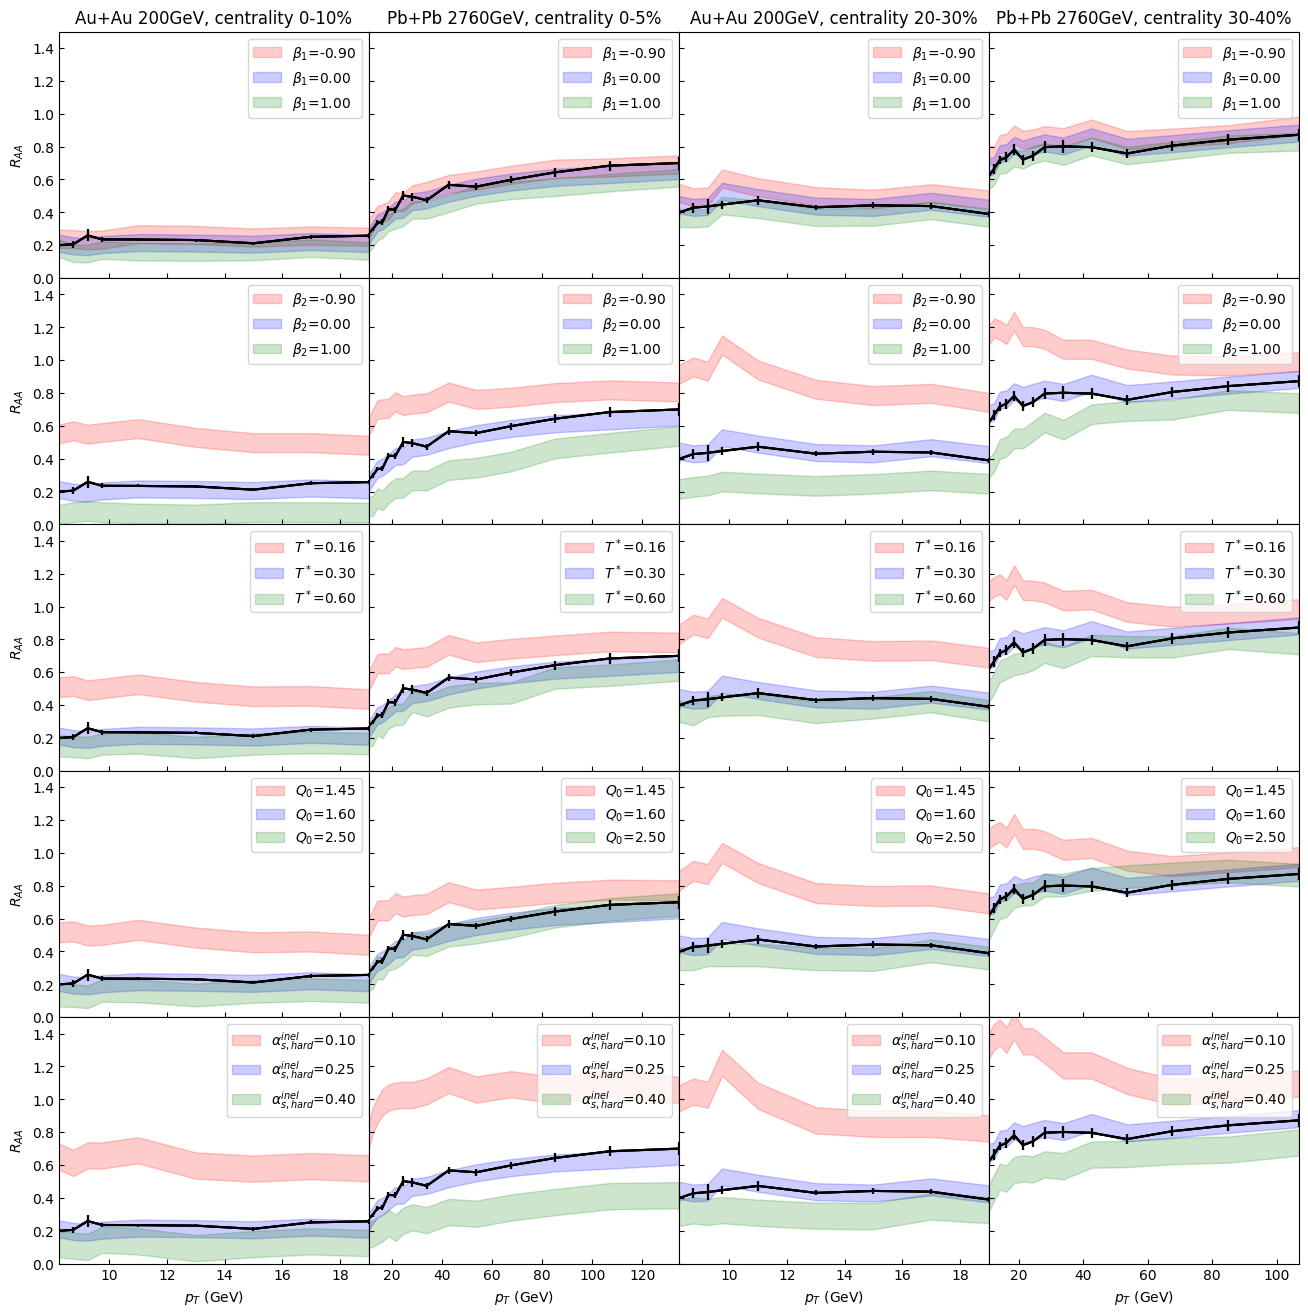

In [10]:
param_samp = np.array([[-0.9, 0., 1.], [-0.9, 0., 1.], [0.16, 0.3, 0.6], [1.45, 1.6, 2.5], [0.1, 0.25, 0.4]])
ParameterLabels = ['$\\beta_1$', '$\\beta_2$', '$T^*$', '$Q_0$', '$\\alpha^{inel}_{s, hard}$']
colors = ['r', 'b', 'g']

fig, axes = plt.subplots(5,4, figsize=(16,16))
fig.subplots_adjust(hspace=0, wspace=0)
labels = r"$R_{AA}$"

for i, color in enumerate(colors): 
    X_validation = np.array([param_samp.T[1]])

    
    for j, param_label in enumerate(ParameterLabels): 
        X_validation[0, j] = param_samp[j, i]
        Y_predicted, Y_std = GPR.predict(X_validation, return_std=True)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 0].fill_between(pT1,mean[:Nc1]-std[:Nc1],mean[:Nc1]+std[:Nc1],color=color,alpha=.2, label=label)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 1].fill_between(pT2,mean[Nc1:Nc2]-std[Nc1:Nc2],mean[Nc1:Nc2]+std[Nc1:Nc2],color=color,alpha=.2, label=label)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 2].fill_between(pT3,mean[Nc2:Nc3]-std[Nc2:Nc3],mean[Nc2:Nc3]+std[Nc2:Nc3],color=color,alpha=.2, label=label)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 3].fill_between(pT4,mean[Nc3:Nc4]-std[Nc3:Nc4],mean[Nc3:Nc4]+std[Nc3:Nc4],color=color,alpha=.2, label=label)
            
        # label = 'Model calc.' if i == 0 else ''
        axes[j, 0].errorbar(pT1, Y_validation[0][:Nc1], Y_validation_err[0][:Nc1], color='black')
        axes[j, 1].errorbar(pT2, Y_validation[0][Nc1:Nc2], Y_validation_err[0][Nc1:Nc2], color='black')
        axes[j, 2].errorbar(pT3, Y_validation[0][Nc2:Nc3], Y_validation_err[0][Nc2:Nc3], color='black')
        axes[j, 3].errorbar(pT4, Y_validation[0][Nc3:Nc4], Y_validation_err[0][Nc3:Nc4], color='black')
        # axes[j, 0].set_xlabel("$p_T$ (GeV)")
        axes[j, 0].set_ylabel(labels)
        axes[j, 0].legend()
        axes[j, 0].set_ylim(0, 1.5)
        axes[j, 0].set_xlim(8.25, 19)
        # axes[j, 1].set_xlabel("$p_T$ (GeV)")
        # axes[j, 1].set_ylabel(labels)
        axes[j, 1].legend()
        axes[j, 1].set_ylim(0, 1.5)
        axes[j, 1].set_xlim(10.75, 134.5)
        # axes[j, 2].set_xlabel("$p_T$ (GeV)")
        # axes[j, 2].set_ylabel(labels)
        axes[j, 2].legend()
        axes[j, 2].set_ylim(0, 1.5)
        axes[j, 2].set_xlim(8.25, 19)
        # axes[j, 3].set_xlabel("$p_T$ (GeV)")
        # axes[j, 3].set_ylabel(labels)
        axes[j, 3].legend()
        axes[j, 3].set_ylim(0, 1.5)
        axes[j, 3].set_xlim(10.75, 106.9)
        # axes[j, 0].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 1].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 2].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 3].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 0].tick_params(direction="in", which='both')
        axes[j, 1].tick_params(direction="in", which='both')
        axes[j, 2].tick_params(direction="in", which='both')
        axes[j, 3].tick_params(direction="in", which='both')
axes[4, 0].set_xlabel("$p_T$ (GeV)")
axes[4, 1].set_xlabel("$p_T$ (GeV)")
axes[4, 2].set_xlabel("$p_T$ (GeV)")
axes[4, 3].set_xlabel("$p_T$ (GeV)")


# titles = r"centrality 40-50%", r"centrality 40-50%"
# titles = r"Au+Au 200GeV, centrality 0-10%"
# for ax, label, title in zip(axes, labels, titles):
# axes.set_xlabel("$p_T$ (GeV)")
# axes.set_ylabel(labels)
# axes.legend()
# axes.set_ylim(0, 0.5)
axes[0, 0].set_title(r"Au+Au 200GeV, centrality 0-10%")
axes[0, 1].set_title(r"Pb+Pb 2760GeV, centrality 0-5%")
axes[0, 2].set_title(r"Au+Au 200GeV, centrality 20-30%")
axes[0, 3].set_title(r"Pb+Pb 2760GeV, centrality 30-40%")

# plt.tight_layout(True)
plt.savefig(path+"/plots/running_coupling/Emulator_validation")

In [11]:
param_samp = np.array([[-0.9, 0., 1.], [-0.9, 0., 1.], [0.16, 0.3, 0.6], [1.45, 1.6, 2.5], [0.1, 0.25, 0.4]])
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$', 'ln(k)', '$\\alpha^{inel}_{s, hard}$']

In [12]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

def log_posterior(model_parameters):
    # model_parameters = np.array([model_parameters[0], model_parameters[1], model_parameters[1], model_parameters[2], 2, model_parameters[3]])
    # print(model_parameters)
    mn, var = GPR.predict([model_parameters], return_std=True)
    delta_y = mn - y_exp
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)


# Closure Test

In [13]:
# validate with true values
# y_exp = np.loadtxt(path+'/data/true_RAA')
# y_exp_err = np.loadtxt(path+'/data/true_RAA_err')
# y_exp_variance = np.diag(y_exp_err**2)
y_exp = np.loadtxt(path+'/data/running_coupling/data_val_4obs')
y_exp_err = np.loadtxt(path+'/data/running_coupling/data_val_err_4obs')
y_exp_variance = np.diag(y_exp_err**2)

# print(y_err.shape)
# y_exp = simulation[7]
# y_err = np.loadtxt(path+'/data/RAA_data_err')
# y_exp_variance = np.diag(y_err**2)

## Reduce parameter dim to 4

In [14]:
test_max = np.array([1., 1., 0.6, 2.5, 0.4])
test_min = np.array([-0.9, -0.9, 0.16, 1.45, 0.1])
test_ptp = test_max - test_min

test_dim = 5

In [15]:
nwalkers = 10*test_dim  # number of MCMC walkers
nburn = 2000 # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = test_min + (test_max - test_min) * np.random.rand(nwalkers, test_dim)

#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, test_dim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

# n_samples = len(samples)
# samples = np.concatenate((np.array([samples.T[0]]), np.array([samples.T[0]]), np.array([samples.T[1:3]]), np.array([[2 for _ in range(n_samples)]]), np.array([samples.T[3]])), axis=-1)
# print(samples.shape)

np.savetxt(path+'/data/running_coupling/MCMC_test_samples', samples)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
burn in sampling started


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.43it/s]


Mean acceptance fraction: 0.489 (in total 100000 steps)
Burn in completed.
Now running the samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 74.67it/s]


Mean acceptance fraction: 0.489 (in total 250000 steps)


In [16]:
USE_MAP = True
if USE_MAP:
    bounds=[(a,b) for (a,b) in zip(test_min,test_max)]
    parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
else:
    parameters0 = [np.percentile(it,50) for it in samples.T]

In [17]:
true_values = np.array([0., 0., 0.3, 1.6, 0.25])
# true_values = design[7]

In [18]:
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$', 'log(k)', '$\\alpha^{inel}_{s, hard}$']
ranges = np.array([[-0.9, 1], [-0.9, 1], [0.16, 0.6], [1.45, 2.5], [0.1, 0.4]])

In [19]:
print(samples.shape)

(250000, 5)


/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please upd

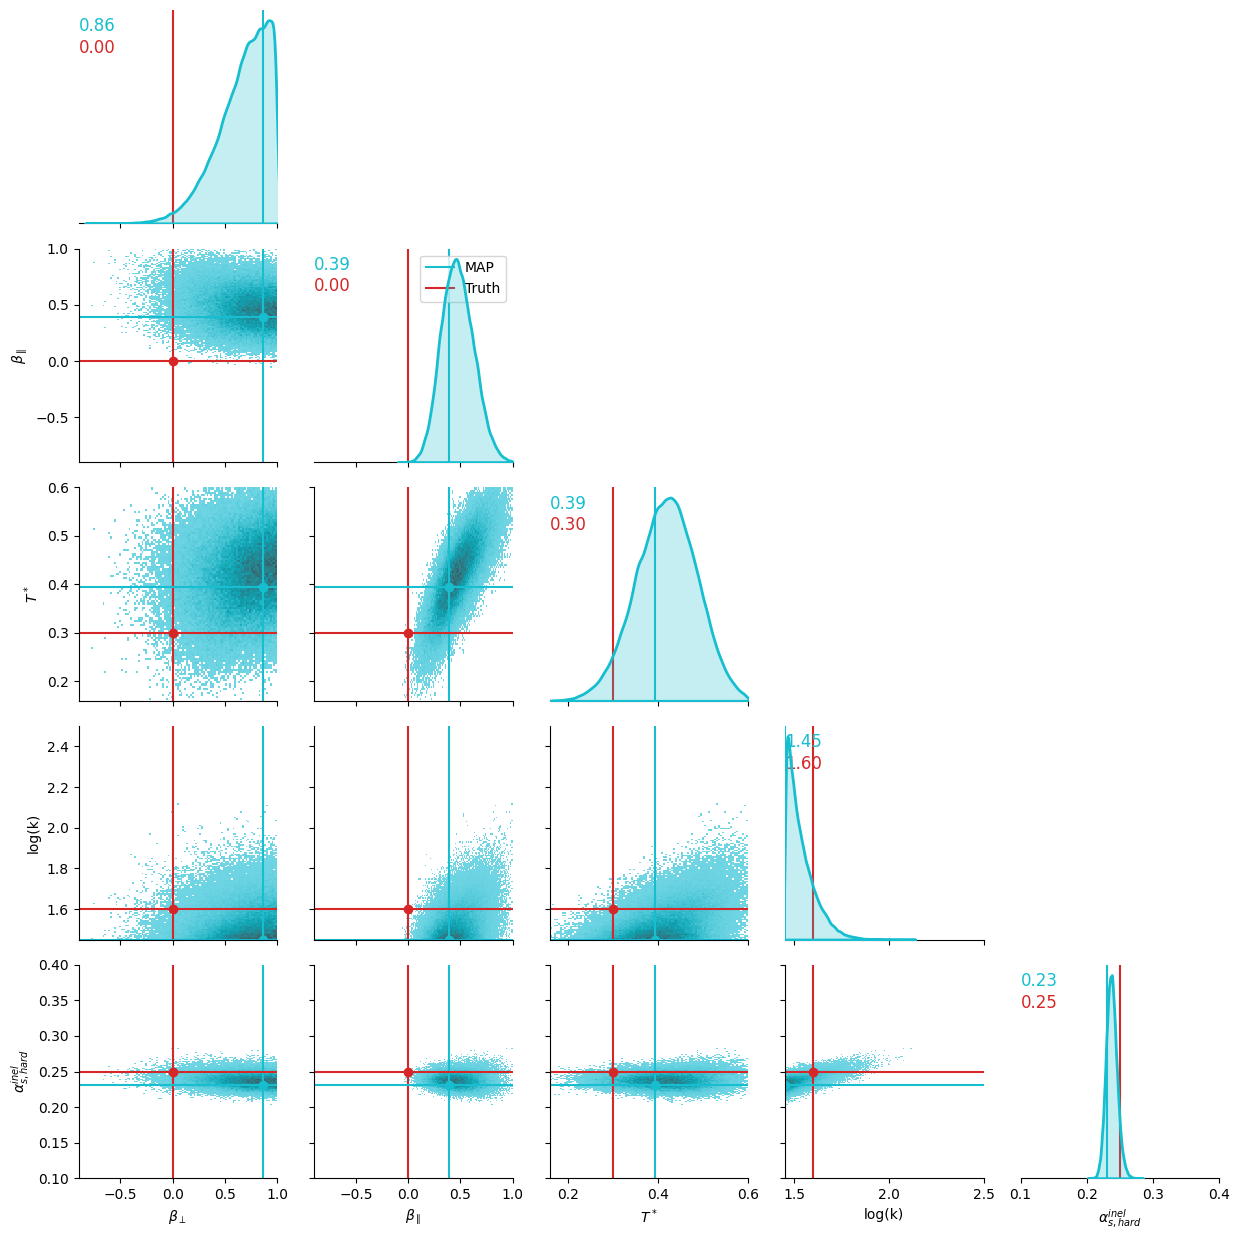

In [20]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(test_dim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[9], label='MAP')
    ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='upper right', fontsize=10)
for i in range(test_dim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[9])
            g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/running_coupling/Posterior_of_true_parameters_pca1_lower1-5_param5_dps40')

In [21]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,test_dim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values
# prior_params = np.concatenate((np.array([prior_params.T[0]]).T, np.array([prior_params.T[1]]).T, prior_params.T[1:3].T, np.array([[2 for _ in range(Nsamples)]]).T, np.array([prior_params.T[3]]).T), axis=1)
# posterior_params = np.concatenate((np.array([posterior_params.T[0]]).T, np.array([posterior_params.T[1]]).T, posterior_params.T[1:3].T, np.array([[2 for _ in range(len(posterior_params))]]).T, np.array([posterior_params.T[3]]).T), axis=1)

prior_obs = []
posterior_obs = []

prior_obs = GPR.predict(prior_params)
posterior_obs = GPR.predict(posterior_params)
"""
for p in prior_params: 
    # A = np.array([predict_observables(p, diag_std=True)])
    # Y_predicted = A[:,0,:]
    Y_predicted = GPR.predict(p)
    # prior_obs = np.array([np.concatenate(Y_predicted)])
    prior_obs.append(list(Y_predicted[0]))

for p in posterior_params: 
    # A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = GPR.predict(p)
    # Y_predicted = A[:,0,:]
    posterior_obs.append(list(Y_predicted[0]))
"""    
prior_obs = np.array(prior_obs)
posterior_obs = np.array(posterior_obs)

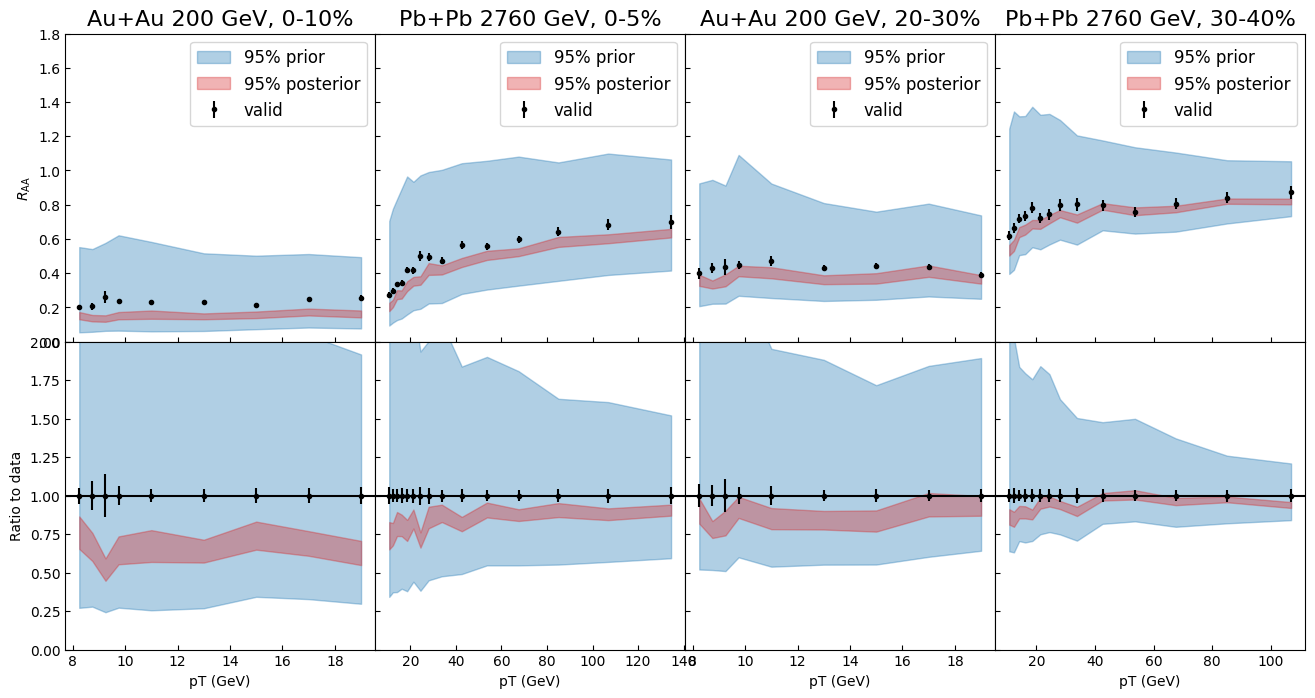

In [22]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
fig.subplots_adjust(hspace=0, wspace=0)
CLbins = [95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0, 0].fill_between(pT1, lower[:Nc1], upper[:Nc1], color=color, alpha=opacity, label=label)
        axes[0, 1].fill_between(pT2, lower[Nc1:Nc2], upper[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[0, 2].fill_between(pT3, lower[Nc2:Nc3], upper[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[0, 3].fill_between(pT4, lower[Nc3:Nc4], upper[Nc3:Nc4], color=color, alpha=opacity, label=label)
        axes[1, 0].fill_between(pT1, (lower/y_exp)[:Nc1], (upper/y_exp)[:Nc1], color=color, alpha=opacity, label=label)
        axes[1, 1].fill_between(pT2, (lower/y_exp)[Nc1:Nc2], (upper/y_exp)[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[1, 2].fill_between(pT3, (lower/y_exp)[Nc2:Nc3], (upper/y_exp)[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[1, 3].fill_between(pT4, (lower/y_exp)[Nc3:Nc4], (upper/y_exp)[Nc3:Nc4], color=color, alpha=opacity, label=label)

for i, ax,y,yerr,name, pT in zip(range(4), axes[0], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]], [y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]], 
                    [r"$R_{\rm AA}$"]*4, [pT1, pT2, pT3, pT4]):

    ax.errorbar(pT, y, yerr=yerr, fmt='k.', label='valid')
    if i == 0:
        ax.set_ylabel(r"$R_{\rm AA}$")
    # ax.set_xlabel("pT (GeV)")

for i, ax,y,yerr,name, pT in zip(range(4), axes[1], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]],[y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]],
                    ["Ratio to data"]*4, [pT1, pT2, pT3, pT4]):
    ax.errorbar(pT, y/y, yerr=yerr/y, fmt='k.', label='valid')
    ax.axhline(y=1, ls='-', color='k')
    if i == 0: 
        ax.set_ylabel("Ratio to data")
    ax.set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0, 0].set_ylim(0,1.8)
axes[0, 1].set_ylim(0,1.8)
axes[0, 2].set_ylim(0,1.8)
axes[0, 3].set_ylim(0,1.8)
axes[1, 0].set_ylim(0,2)
axes[1, 1].set_ylim(0,2)
axes[1, 2].set_ylim(0,2)
axes[1, 3].set_ylim(0,2)
axes[0, 0].set_title('Au+Au 200 GeV, 0-10%', fontsize=16)
axes[0, 1].set_title('Pb+Pb 2760 GeV, 0-5%', fontsize=16)
axes[0, 2].set_title('Au+Au 200 GeV, 20-30%', fontsize=16)
axes[0, 3].set_title('Pb+Pb 2760 GeV, 30-40%', fontsize=16)
axes[0, 0].legend(prop={'size': 12})
axes[0, 1].legend(prop={'size': 12})
axes[0, 2].legend(prop={'size': 12})
axes[0, 3].legend(prop={'size': 12})
axes[0, 1].tick_params(axis='y', which='both', labelleft=False)
axes[0, 2].tick_params(axis='y', which='both', labelleft=False)
axes[0, 3].tick_params(axis='y', which='both', labelleft=False)
axes[1, 1].tick_params(axis='y', which='both', labelleft=False)
axes[1, 2].tick_params(axis='y', which='both', labelleft=False)
axes[1, 3].tick_params(axis='y', which='both', labelleft=False)
axes[0, 0].tick_params(direction="in", which='both')
axes[0, 1].tick_params(direction="in", which='both')
axes[0, 2].tick_params(direction="in", which='both')
axes[0, 3].tick_params(direction="in", which='both')
axes[1, 0].tick_params(direction="in", which='both')
axes[1, 1].tick_params(direction="in", which='both')
axes[1, 2].tick_params(direction="in", which='both')
axes[1, 3].tick_params(direction="in", which='both')

# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
# plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_validation_lower1-20_param5")

# Data analysis

In [23]:
y_exp = np.loadtxt(path+'/data/running_coupling/data_exp_4obs')
y_exp_err = np.loadtxt(path+'/data/running_coupling/data_exp_err_4obs')
y_exp_variance = np.diag(y_exp_err**2)

In [24]:
Xdim = 5
nwalkers = 10*Xdim  # number of MCMC walkers
nburn = 2000 # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers, Xdim)
#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, Xdim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

np.savetxt(path+'/data/running_coupling/MCMC_samples', samples)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
burn in sampling started


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.99it/s]


Mean acceptance fraction: 0.407 (in total 100000 steps)
Burn in completed.
Now running the samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:05<00:00, 76.53it/s]


Mean acceptance fraction: 0.408 (in total 250000 steps)


In [25]:
USE_MAP = True
if USE_MAP:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
else:
    parameters0 = [np.percentile(it,50) for it in samples.T]

/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/tianyu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please upd

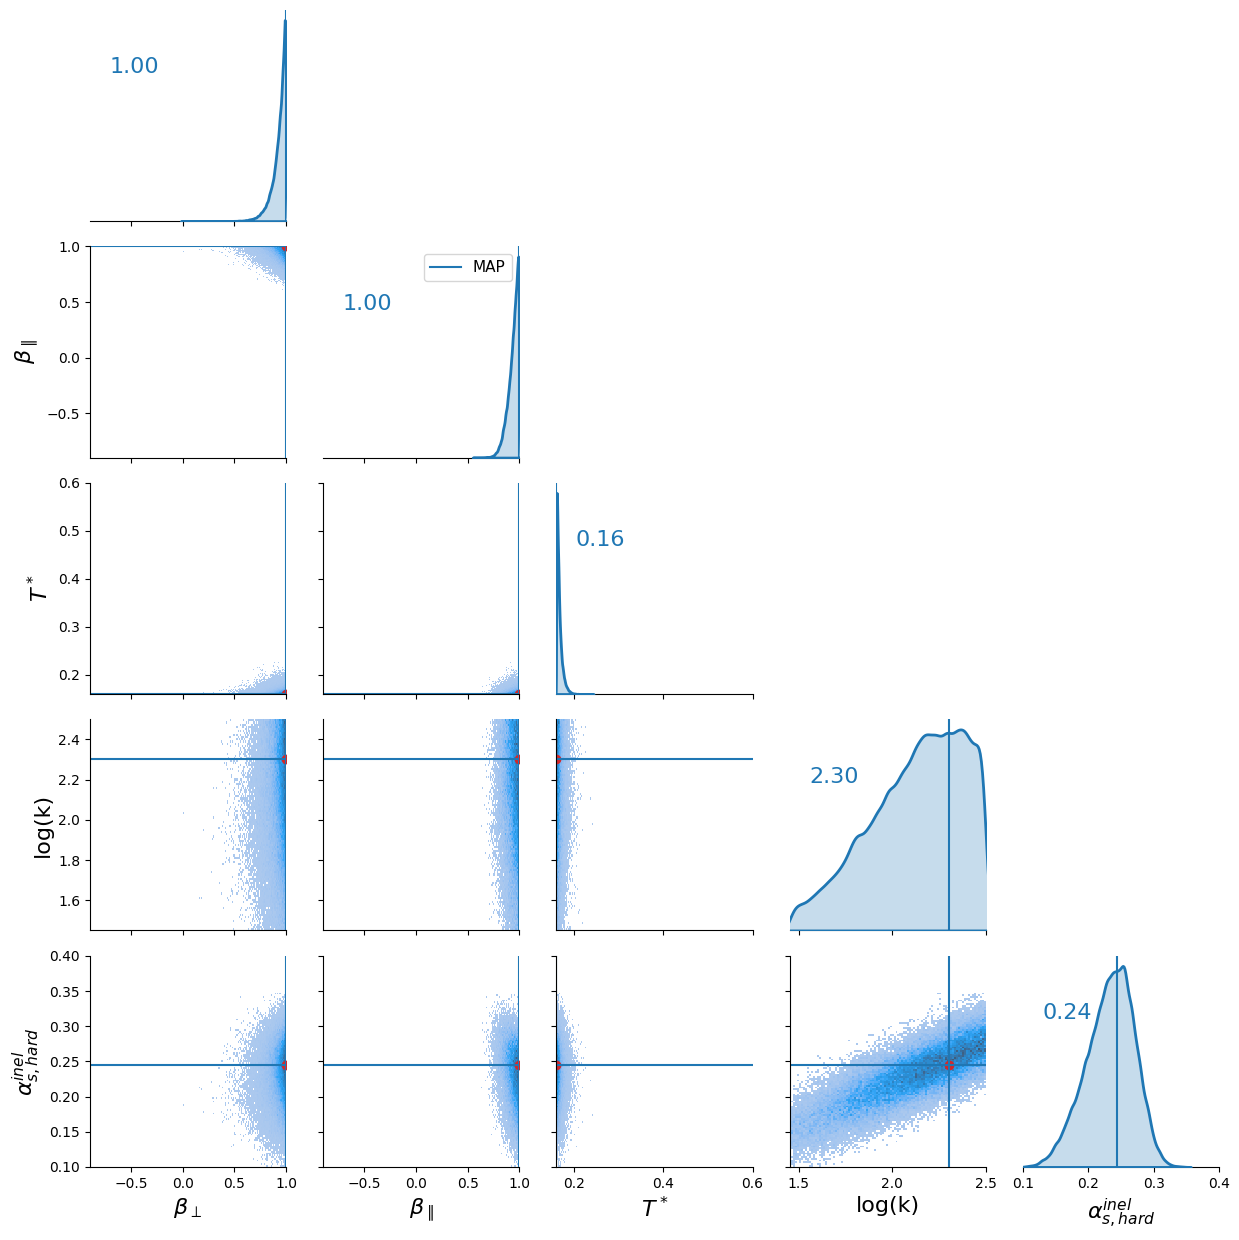

In [26]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
plt.rcParams["axes.labelsize"] = 16
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[0])
for n in range(Xdim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[0], label='MAP')
    # ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0.1,0.7,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[0], fontsize=16)
    # ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=11)
for i in range(Xdim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            # g.axes[i,j].set_ylim(0, 2)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[0])
            # g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[0])
            # g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[3])
            # g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/running_coupling/Posterior_of_parameters_test')

In [27]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values
prior_obs = GPR.predict(prior_params)
posterior_obs = GPR.predict(posterior_params)

"""
for p in prior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    # prior_obs = np.array([np.concatenate(Y_predicted)])
    prior_obs.append(list(Y_predicted[0]))

for p in posterior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    posterior_obs.append(list(Y_predicted[0]))
"""    
prior_obs = np.array(prior_obs)
posterior_obs = np.array(posterior_obs)

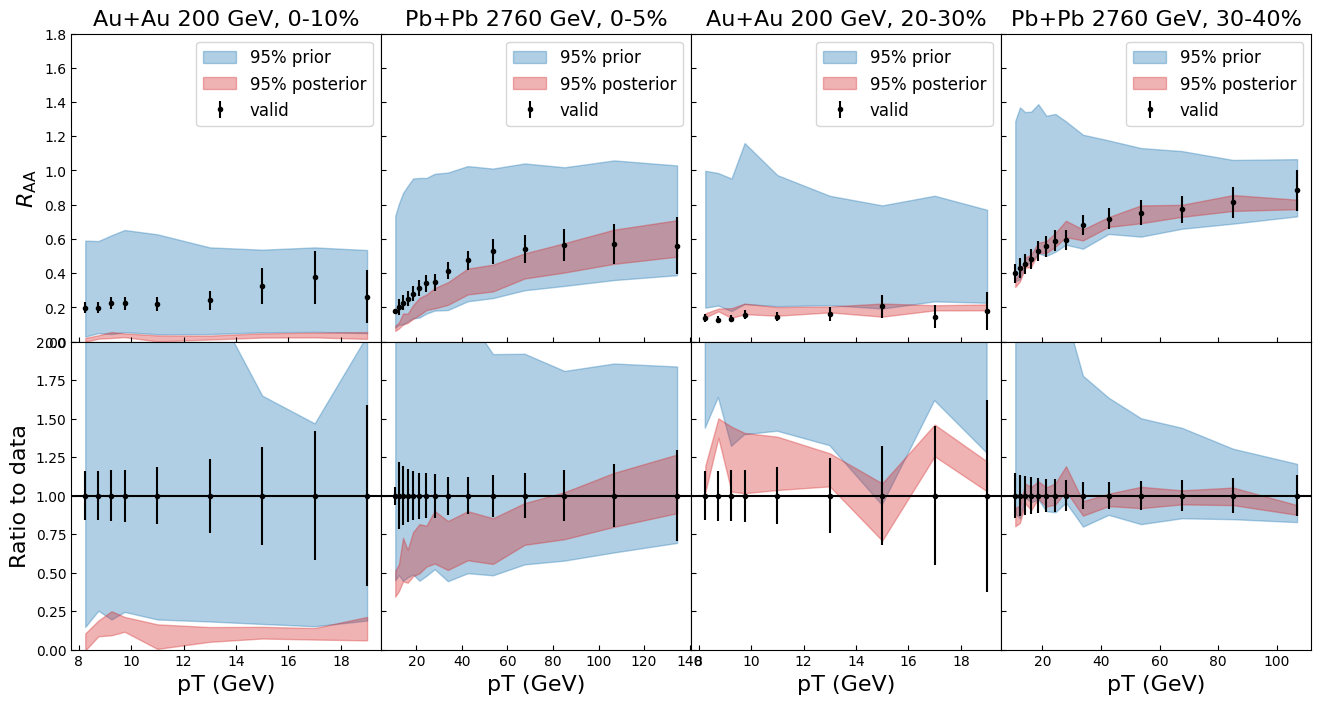

In [28]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
fig.subplots_adjust(hspace=0, wspace=0)
CLbins = [95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0, 0].fill_between(pT1, lower[:Nc1], upper[:Nc1], color=color, alpha=opacity, label=label)
        axes[0, 1].fill_between(pT2, lower[Nc1:Nc2], upper[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[0, 2].fill_between(pT3, lower[Nc2:Nc3], upper[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[0, 3].fill_between(pT4, lower[Nc3:Nc4], upper[Nc3:Nc4], color=color, alpha=opacity, label=label)
        axes[1, 0].fill_between(pT1, (lower/y_exp)[:Nc1], (upper/y_exp)[:Nc1], color=color, alpha=opacity, label=label)
        axes[1, 1].fill_between(pT2, (lower/y_exp)[Nc1:Nc2], (upper/y_exp)[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[1, 2].fill_between(pT3, (lower/y_exp)[Nc2:Nc3], (upper/y_exp)[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[1, 3].fill_between(pT4, (lower/y_exp)[Nc3:Nc4], (upper/y_exp)[Nc3:Nc4], color=color, alpha=opacity, label=label)

for i, ax,y,yerr,name, pT in zip(range(4), axes[0], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]], [y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]], 
                    [r"$R_{\rm AA}$"]*4, [pT1, pT2, pT3, pT4]):

    ax.errorbar(pT, y, yerr=yerr, fmt='k.', label='valid')
    if i == 0:
        ax.set_ylabel(r"$R_{\rm AA}$")
    # ax.set_xlabel("pT (GeV)")

for i, ax,y,yerr,name, pT in zip(range(4), axes[1], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]],[y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]],
                    ["Ratio to data"]*4, [pT1, pT2, pT3, pT4]):
    ax.errorbar(pT, y/y, yerr=yerr/y, fmt='k.', label='valid')
    ax.axhline(y=1, ls='-', color='k')
    if i == 0: 
        ax.set_ylabel("Ratio to data")
    ax.set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0, 0].set_ylim(0,1.8)
axes[0, 1].set_ylim(0,1.8)
axes[0, 2].set_ylim(0,1.8)
axes[0, 3].set_ylim(0,1.8)
axes[1, 0].set_ylim(0,2)
axes[1, 1].set_ylim(0,2)
axes[1, 2].set_ylim(0,2)
axes[1, 3].set_ylim(0,2)
axes[0, 0].set_title('Au+Au 200 GeV, 0-10%', fontsize=16)
axes[0, 1].set_title('Pb+Pb 2760 GeV, 0-5%', fontsize=16)
axes[0, 2].set_title('Au+Au 200 GeV, 20-30%', fontsize=16)
axes[0, 3].set_title('Pb+Pb 2760 GeV, 30-40%', fontsize=16)
axes[0, 0].legend(prop={'size': 12})
axes[0, 1].legend(prop={'size': 12})
axes[0, 2].legend(prop={'size': 12})
axes[0, 3].legend(prop={'size': 12})
axes[0, 1].tick_params(axis='y', which='both', labelleft=False)
axes[0, 2].tick_params(axis='y', which='both', labelleft=False)
axes[0, 3].tick_params(axis='y', which='both', labelleft=False)
axes[1, 1].tick_params(axis='y', which='both', labelleft=False)
axes[1, 2].tick_params(axis='y', which='both', labelleft=False)
axes[1, 3].tick_params(axis='y', which='both', labelleft=False)
axes[0, 0].tick_params(direction="in", which='both')
axes[0, 1].tick_params(direction="in", which='both')
axes[0, 2].tick_params(direction="in", which='both')
axes[0, 3].tick_params(direction="in", which='both')
axes[1, 0].tick_params(direction="in", which='both')
axes[1, 1].tick_params(direction="in", which='both')
axes[1, 2].tick_params(direction="in", which='both')
axes[1, 3].tick_params(direction="in", which='both')

# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
# plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_validation_lower1-20_param5")